In [1]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import platform
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [8]:
def find_divide_indices(stim_table):
    # Find the indices where each new stimulus presentation after the first presentation starts
    divide_indices = []

    for i in range(min(stim_table.index), max(stim_table.index)):
        try:
            if stim_table.start[i+1]-stim_table.end[i] > 100:
                divide_indices.append(i) # saves index where new stim presentation begins
        except:
            pass
    return divide_indices

In [9]:
def divide_stim_table(stim_table, divide_indices=[]):
    '''
    Divides input stimulus table based on indices corresponding to separate stimulus
    presentations.
    
    If there were 3 presentations, three dataframes for each presentation are returned. 
    If there were 2 presentations, three dataframes for each presentation are still 
    returned with the third being null.
    '''
    if len(divide_indices)==2: # 3 presentations 
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:divide_indices[1]], stim_table.loc[divide_indices[1]+1:]
    elif len(divide_indices) == 1: # 2 presentations
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:], pd.DataFrame()
    else:
        raise Exception("Stimulis has only one presentation. Nothing to divide.")

In [62]:
def generate_response_matrices(stim_table, all_events):
    '''
    This function generates response matrices given an input stimulus table. 
    Stimulus table can be divided based ons timulus presentations, or undivided.
    '''
    # generate response matrix
    response = np.empty((len(all_events.index), len(stim_table), 60)) # 3d array for responses at each frame to each stimulus for each neuron
    stim_table = stim_table.reset_index(drop=True)
    for i in range(len(stim_table)):
        for cell_index in range(len(all_events.index)):
            response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+60]
    
    # response matrix contains the response at each frame for every stimulus presentation for each
    # cell contained in the session
    
    if stim_table.stim_category[0] == "drifting_gratings" or stim_table.stim_category[0] == "static_gratings":
        # orientation matrix shows the orientation value for each frame, likewise for temporal frequency matrix
        orientation_matrix = np.zeros(len(stim_table))
        frequency_matrix = np.zeros(len(stim_table))

        # Loop through each stimulus presentation, store its parameters
        for i in range(len(stim_table)):
            # extract orientation and temporal frequency info by splitting stimulus ID
            orientation_matrix[i] = stim_table.stim_id[i].split("_")[0]
            frequency_matrix[i] = stim_table.stim_id[i].split("_")[1]
        
        return orientation_matrix, frequency_matrix, response


In [336]:
def responses_per_stimulus(stim_table, response_matrix):
    responses_by_stimulus = pd.DataFrame(columns=["stim_id","response_matrix"])
    
    for stim_id in np.unique(stim_table.stim_id):
        temp_stim_id_df = stim_table[stim_table.stim_id==stim_id]
        # below we are indexing the responses in the response matrix corresponding to the target 
        # stim ID values. The indices of target stim ID may be greater than the response matrix 
        # size since we devided the stimulus tables based on when the presentation was shown.
        # So we subtract the indices of each target stim ID by the first index of the stim table, 
        # to normalize the values.
        response_stimulus_matrix = response_matrix[:,list(temp_stim_id_df.index-stim_table.index[0]),:]
        responses_by_stimulus.loc[len(responses_by_stimulus)] = [stim_id, response_stimulus_matrix]
    
    return responses_by_stimulus

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [175]:
# Select the relevant data for chosen container ID
desired_container_id = 688678764
desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first

# Get session IDs for each session
session_one_id = desired_container[0]["id"]

# load in session data for each session
session_one = boc.get_ophys_experiment_data(ophys_experiment_id=session_one_id)

# Get all event traces for all neurons in given session 
all_events = get_events(boc, session_one_id, "VISp")

# Get full stimulus table for a given session
stim_table = create_stim_df(boc, session_one_id)

In [6]:
# Drifting gratings, session 1

In [176]:
drifting_gratings_table = stim_table[stim_table.stim_category == "drifting_gratings"]

In [177]:
divide_indices = find_divide_indices(drifting_gratings_table)

In [178]:
dg1, dg2, dg3 = divide_stim_table(drifting_gratings_table, divide_indices)

In [360]:
len(np.unique(dg1.stim_id))

41

In [361]:
len(np.unique(dg2.stim_id))

41

In [363]:
len(np.unique(dg3.stim_id))

40

In [211]:
orientation1, freq1, response1 = generate_response_matrices(dg1, all_events)
orientation2, freq2, response2 = generate_response_matrices(dg2, all_events)
orientation3, freq3, response3 = generate_response_matrices(dg3, all_events)

In [ ]:
# Create dataframe with response matrix for each stimulus ID

In [349]:
dg1_responses_by_stimulus = responses_per_stimulus(dg1, response1)
dg2_responses_by_stimulus = responses_per_stimulus(dg2, response2)
dg3_responses_by_stimulus = responses_per_stimulus(dg3, response3)

In [372]:
dg1_responses_by_stimulus

,stim_id,response_matrix
0,0.0_1.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,0.0_15.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,0.0_2.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,0.0_4.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.11472957475108049, 0...."
4,0.0_8.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
5,135.0_1.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,135.0_15.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,135.0_2.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,135.0_4.0_0.0,"[[[0.0, 0.0, 0.0, 0.15039327949444795, 0.0, 0...."
9,135.0_8.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [373]:
responses_by_stimulus = dg1_responses_by_stimulus.copy()
responses_by_stimulus["response_matrix2"] = dg2_responses_by_stimulus.response_matrix
responses_by_stimulus["response_matrix3"] = dg3_responses_by_stimulus.response_matrix

In [405]:
matrix1 = responses_by_stimulus[responses_by_stimulus.stim_id=='0.0_1.0_0.0'].response_matrix[0]
matrix2 = responses_by_stimulus[responses_by_stimulus.stim_id=='0.0_1.0_0.0'].response_matrix2[0]
matrix3 = responses_by_stimulus[responses_by_stimulus.stim_id=='0.0_1.0_0.0'].response_matrix3[0]

np.nanmean(np.nanmean(matrix1),np.nanmean(matrix2),np.nanmean(matrix3))


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [380]:
means = []

for stim_id in np.unique(responses_by_stimulus.stim_id):
    matrix1 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix[0]
    matrix2 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix2[0]
    matrix3 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix3[0]

    means.append(np.nanmean(responses_by_stimulus.loc[stim_id]))
    responses_by_stimulus["mean"] = means
    

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [374]:
responses_by_stimulus

,stim_id,response_matrix,response_matrix2,response_matrix3
0,0.0_1.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,0.0_15.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,0.0_2.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,0.0_4.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.11472957475108049, 0....","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.1724930068544047...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,0.0_8.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
5,135.0_1.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,135.0_15.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,135.0_2.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,135.0_4.0_0.0,"[[[0.0, 0.0, 0.0, 0.15039327949444795, 0.0, 0....","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,135.0_8.0_0.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [ ]:
# Calculate mean responses 

In [212]:
mean1 = np.nanmean(response1)
mean2 = np.nanmean(response2)
mean3 = np.nanmean(response3)

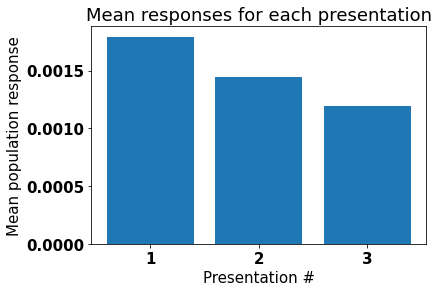

In [213]:
plt.bar([1,2,3],[mean1, mean2, mean3])
plt.title("Mean responses for each presentation")
plt.xticks([1,2,3])
plt.ylabel("Mean population response")
plt.xlabel("Presentation #")
plt.show()

In [ ]:
# Static gratings, session 2 

In [93]:
# Get session IDs for each session
session_two_id = desired_container[1]["id"]

# load in session data for each session
session_two = boc.get_ophys_experiment_data(ophys_experiment_id=session_two_id)

# Get all event traces for all neurons in given session 
all_events = get_events(boc, session_two_id, "VISp")

# Get full stimulus table for a given session
stim_table = create_stim_df(boc, session_two_id)

In [97]:
static_gratings_table = stim_table[stim_table.stim_category == "static_gratings"]

In [98]:
divide_indices = find_divide_indices(static_gratings_table)

In [99]:
sg1, sg2, null = divide_stim_table(static_gratings_table, divide_indices)

In [100]:
orientation1, freq1, response1 = generate_response_matrices(sg1, all_events)
orientation2, freq2, response2 = generate_response_matrices(sg2, all_events)

In [ ]:
# Calculate total mean responses 

In [101]:
mean1 = np.nanmean(response1)
mean2 = np.nanmean(response2)
mean3 = np.nanmean(response3)

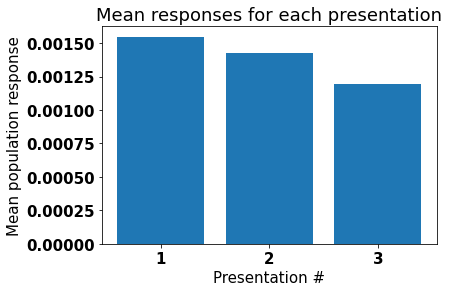

In [102]:
plt.bar([1,2,3],[mean1, mean2, mean3])
plt.title("Mean responses for each presentation")
plt.xticks([1,2,3])
plt.ylabel("Mean population response")
plt.xlabel("Presentation #")
plt.show()

In [ ]:
# Natural scenes, session 2 

In [104]:
natural_scenes_table = stim_table[stim_table.stim_category == "natural_scenes"]

In [106]:
np.unique(natural_scenes_table.stim_id)

array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117], dtype=object)

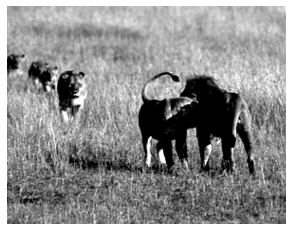

In [123]:
natural_scene_tempate = session_two.get_stimulus_template('natural_scenes')
scene_number=5
plt.imshow(natural_scene_template[scene_number,:,:], cmap='gray')
plt.axis('off');